# Home Credit Default Risk Prediction


In [4]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

from lightgbm import LGBMClassifier

from src.plots import (
    plot_target_distribution,
    plot_credit_amounts,
    plot_education_levels,
    plot_occupation,
    plot_family_status,
    plot_income_type,
)
from src.utils import get_dataset, get_features_target, get_train_test_sets
from src.preprocessing import preprocess_data_pipeline

In [5]:
df = get_dataset()
X, y = get_features_target(df)

## 1. Exploratory Data Analysis


### 1.1 Dataset Information


**a. Shape of the train and test datasets**


**b. Dataset features**


In [6]:
X.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

**c. Sample from dataset**


In [7]:
sample = X.head(5).T
sample.columns = [str(col) for col in sample.columns]  # fix integer name warning
sample = sample.astype(str)  # avoid numeric conversion issues in viewer
sample

,0,1,2,3,4
SK_ID_CURR,428247,140966,407283,434300,446788
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F
FLAG_OWN_CAR,N,Y,N,N,N
FLAG_OWN_REALTY,N,Y,Y,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,nan,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,nan,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_MON,nan,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_QRT,nan,0.0,0.0,1.0,0.0


**d. Target variable Distribution**


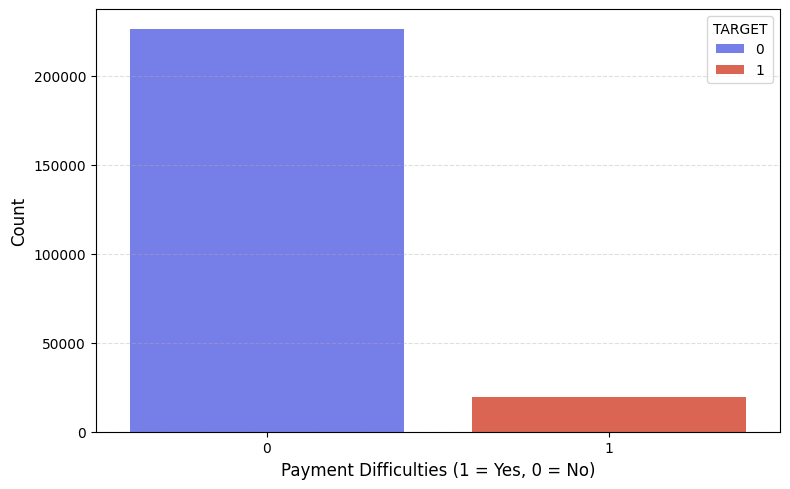

In [40]:
target_table, target_plot = plot_target_distribution(df=df)

**e. Number of columns of each data type**


In [11]:
X.dtypes.value_counts().sort_values(ascending=False)

float64    65
int64      40
object     16
Name: count, dtype: int64

In [13]:
categorical_cols = (
    X.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)
)
categorical_cols

ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
CODE_GENDER                    3
FLAG_OWN_CAR                   2
NAME_CONTRACT_TYPE             2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
dtype: int64

**f. Missing data**


In [14]:
missing_count = X.isna().sum().sort_values(ascending=False)
missing_percentage = (missing_count / X.shape[0] * 100).round(2)

missing_data = pd.DataFrame(
    data={"Count": missing_count, "percentage": missing_percentage}
)
missing_data

,Count,percentage
COMMONAREA_AVG,172189,69.99
COMMONAREA_MEDI,172189,69.99
COMMONAREA_MODE,172189,69.99
NONLIVINGAPARTMENTS_AVG,171096,69.55
NONLIVINGAPARTMENTS_MEDI,171096,69.55
...,...,...
FLAG_DOCUMENT_16,0,0.00
FLAG_DOCUMENT_15,0,0.00
FLAG_DOCUMENT_14,0,0.00
FLAG_DOCUMENT_20,0,0.00


### 1.2 Distribution of Variables


> Want to see how these plots were created? You can find the source code for the visualizations in [plots.py](https://huggingface.co/spaces/iBrokeTheCode/Home_Credit_Default_Risk_Prediction/blob/main/src/plots.py).


**a. Credit Amounts**


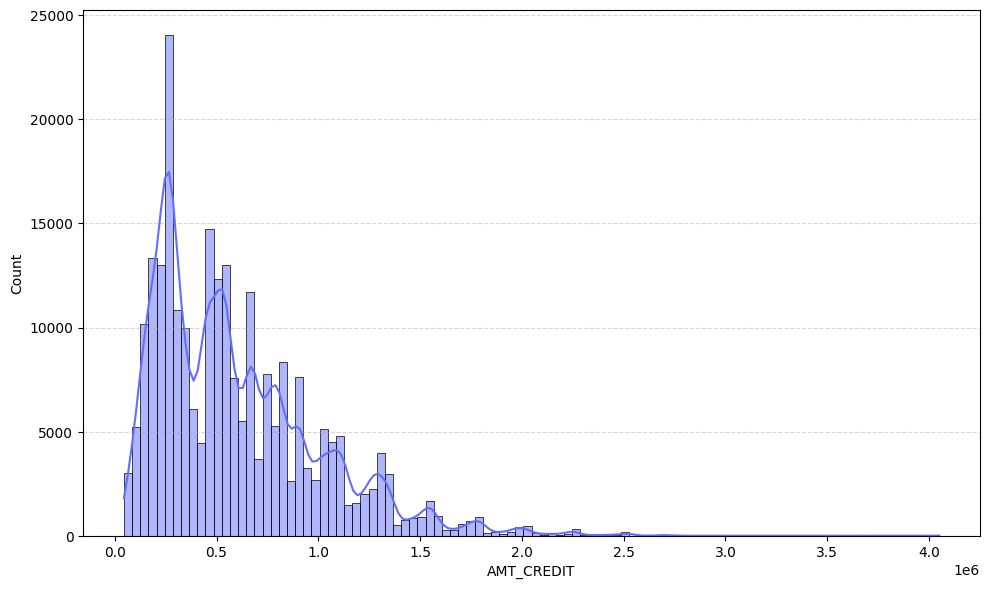

In [25]:
credit_plot = plot_credit_amounts(df=X)

**b. Education Level of Credit Applicants**


,Count,Percentage
NAME_EDUCATION_TYPE,,
Secondary / secondary special,174657,71.00
Higher education,59990,24.39
Incomplete higher,8248,3.35
Lower secondary,2984,1.21
Academic degree,129,0.05


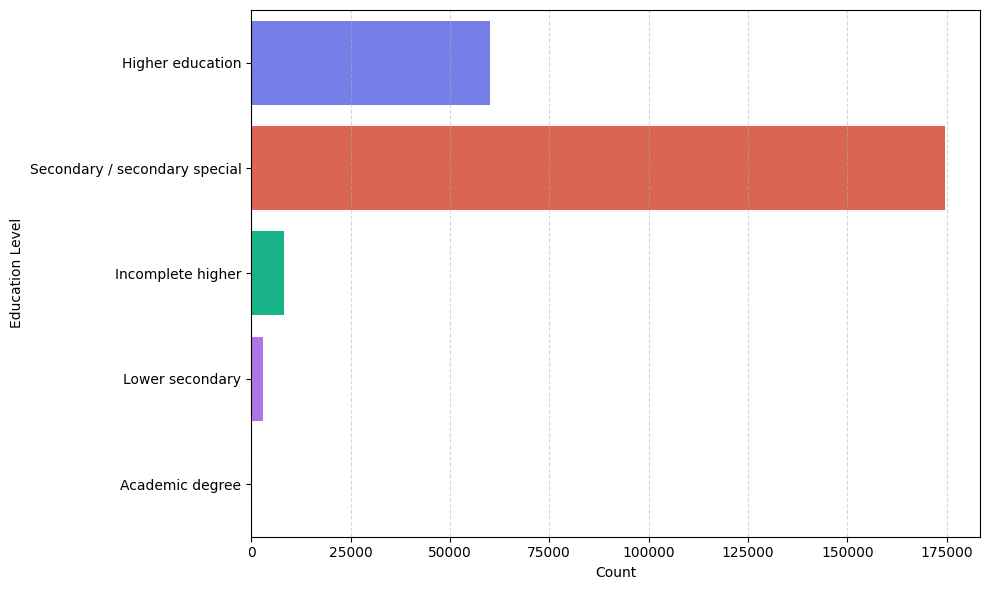

In [16]:
education_table, education_plot = plot_education_levels(df=X)
education_table

**c. Ocupation of Credit Applicants**


OCCUPATION_TYPE
NaN                      77119
Laborers                 44108
Sales staff              25770
Core staff               22041
Managers                 16992
Drivers                  14874
High skill tech staff     8981
Accountants               7915
Medicine staff            6879
Security staff            5364
Cooking staff             4771
Cleaning staff            3731
Private service staff     2140
Low-skill Laborers        1687
Waiters/barmen staff      1094
Secretaries               1043
Realty agents              625
IT staff                   443
HR staff                   431
Name: count, dtype: int64

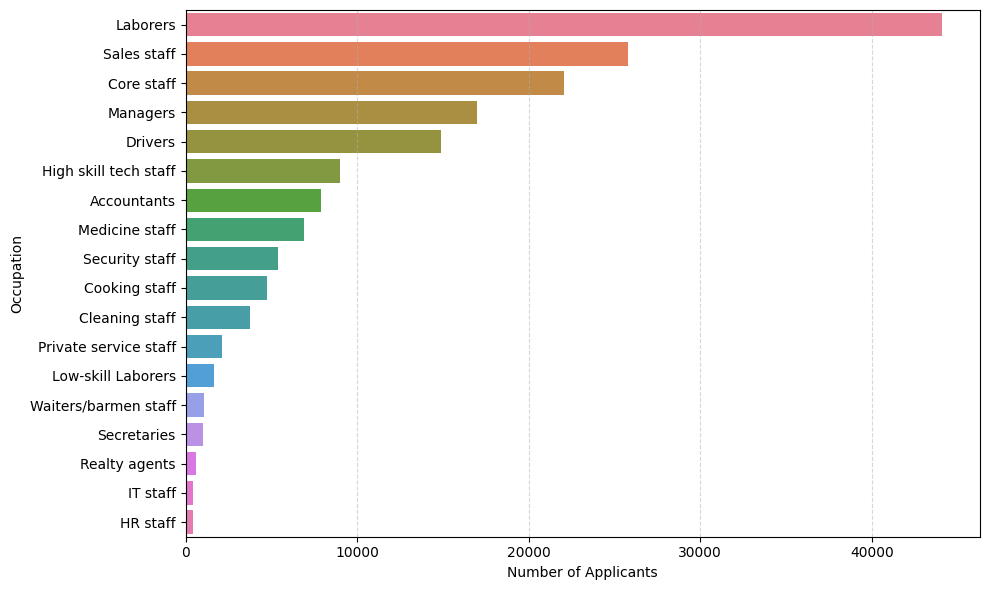

In [18]:
occupation_table, occupation_plot = plot_occupation(df=X)
occupation_table

**d. Family Status of Applicants**


NAME_FAMILY_STATUS
Married                 157165
Single / not married     36315
Civil marriage           23841
Separated                15803
Widow                    12883
Unknown                      1
Name: count, dtype: int64

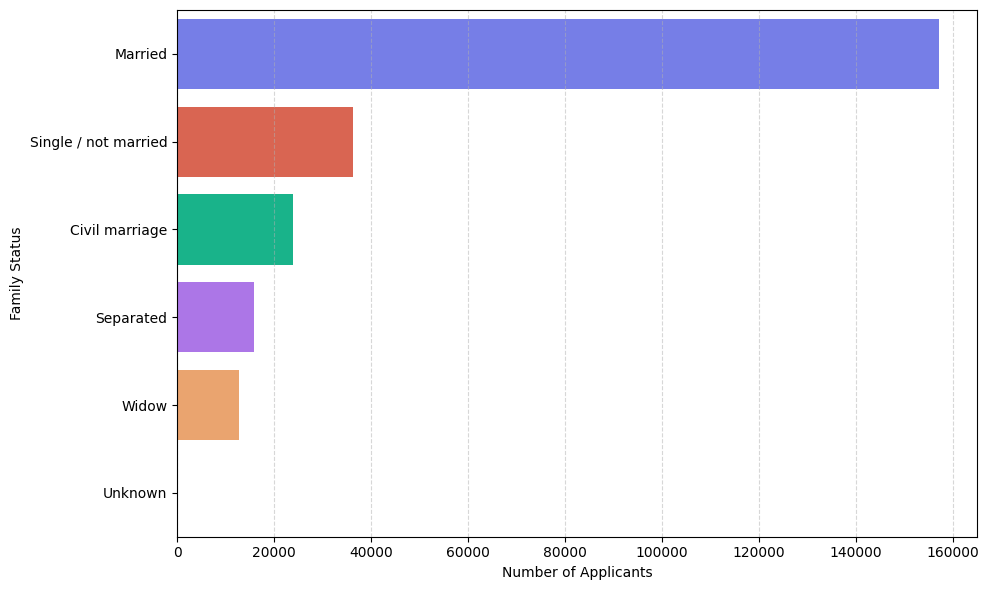

In [21]:
family_status_table, family_status_plot = plot_family_status(df=X)
family_status_table

**e. Income Type of Applicants by Target Variable**


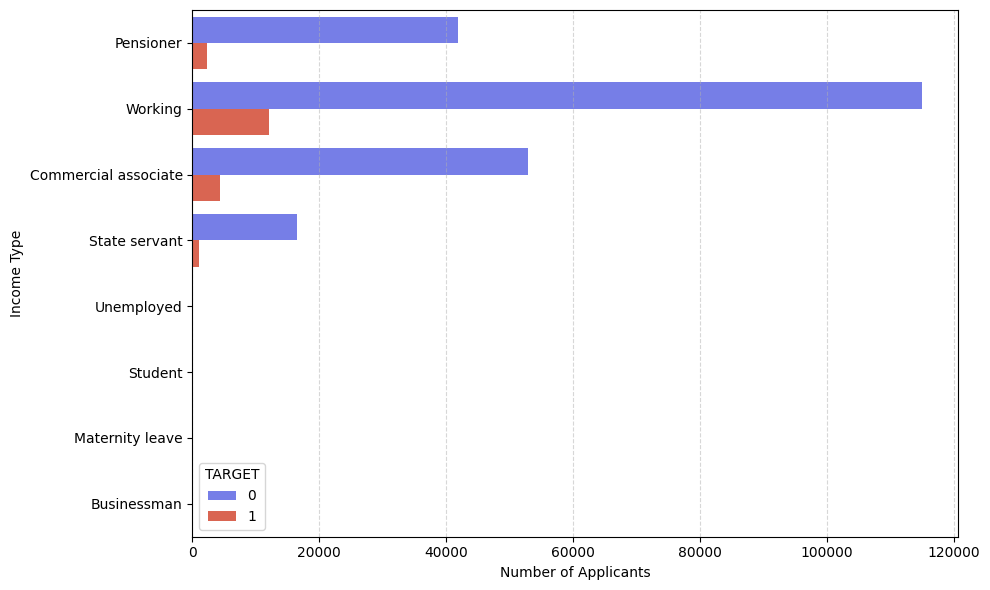

In [ ]:
income_type_plot = plot_income_type(df=df)

## 2. Preprocessing


**a. Separate Train and Test Datasets**


In [26]:
X_train, y_train, X_test, y_test = get_train_test_sets(X, y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((196806, 121), (196806,), (49202, 121), (49202,))

In [27]:
train_samples = "Train dataset samples: {}".format(X_train.shape[0])
test_samples = "Test dataset samples: {}".format(X_test.shape[0])
columns_number = "Number of columns: {}".format(df.shape[1])

train_samples, test_samples, columns_number

('Train dataset samples: 196806',
 'Test dataset samples: 49202',
 'Number of columns: 122')

**b. Preprocess Data**


This preprocessing perform:

- Correct outliers/anomalous values in numerical columns (`DAYS_EMPLOYED` column).
- Encode string categorical features (`dtype object`).
  - If the feature has 2 categories, Binary Encoding is applied.
  - One Hot Encoding for more than 2 categories.
- Impute values for all columns with missing data (using median as imputing value).
- Feature scaling with Min-Max scaler

> Want to see how the dataset was processed? You can find the code for the preprocessing steps in [preprocessing.py](<[./src/preprocessing.py](https://huggingface.co/spaces/iBrokeTheCode/Home_Credit_Default_Risk_Prediction/blob/main/src/preprocessing.py)>).


In [28]:
train_data, test_data = preprocess_data_pipeline(train_df=X_train, test_df=X_test)
train_data.shape, test_data.shape

((196806, 241), (49202, 241))

## 3. Training Models


At this points, we will work with `train_data` and `test_data` as features sets; also `y_train` and `y_test` as target sets.


### 3.1 Logistic Regression


In Logistic Regression, C is the inverse of regularization strength:

- **Small C** → Stronger regularization → Simpler model, less overfitting risk, but may underfit.
- **Large C** → Weaker regularization → Model fits training data more closely, but may overfit.


In [31]:
# 📌 Logistic Regression
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

# Train data predicton (class 1)
lr_train_pred = log_reg.predict_proba(train_data)[:, 1]

# Test data prediction (class 1)
lr_test_pred = log_reg.predict_proba(test_data)[:, 1]


📈 The ROC AUC scores obtained:


In [32]:
log_reg_scores = {
    "train_score": roc_auc_score(y_train, lr_train_pred),
    "test_score": roc_auc_score(y_test, lr_test_pred),
}
log_reg_scores

{'train_score': 0.6868418961663535, 'test_score': 0.6854973003347028}

### 3.2 Random Forest Classifier


In [33]:
# 📌 Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(train_data, y_train)

rf_train_pred = rf.predict_proba(train_data)[:, 1]
rf_test_pred = rf.predict_proba(test_data)[:, 1]


📈 The ROC AUC scores obtained:


In [34]:
rf_scores = {
    "train_score": roc_auc_score(y_train, rf_train_pred),
    "test_score": roc_auc_score(y_test, rf_test_pred),
}
rf_scores

{'train_score': 1.0, 'test_score': 0.7066811557903828}

### 3.3. Randomized Search with Cross Validations


In [35]:
# 📌 RandomizedSearchCV
param_dist = {"n_estimators": [50, 100, 150], "max_depth": [10, 20, 30]}

rf_optimized = RandomForestClassifier(random_state=42, n_jobs=-1)
rscv = RandomizedSearchCV(
    estimator=rf_optimized,
    param_distributions=param_dist,
    n_iter=5,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1,
)

rscv.fit(train_data, y_train)

rfo_train_pred = rscv.predict_proba(train_data)[:, 1]
rfo_test_pred = rscv.predict_proba(test_data)[:, 1]


📈 The ROC AUC scores obtained:


In [36]:
rfo_scores = {
    "train_score": roc_auc_score(y_train, rfo_train_pred),
    "test_score": roc_auc_score(y_test, rfo_test_pred),
}
rfo_scores

{'train_score': 0.8196620915431655, 'test_score': 0.7308385425476998}

🥇The best results:


In [37]:
optimized_results = {
    "best_params_": {"n_estimators": 100, "max_depth": 10},
    "best_score_": 0.7296259755147781,
    "best_estimator_": "RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)",
}
optimized_results

{'best_params_': {'n_estimators': 100, 'max_depth': 10},
 'best_score_': 0.7296259755147781,
 'best_estimator_': 'RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)'}

### 3.4 LightGBM


In [38]:
# 📌 LightGBM
import warnings

warnings.filterwarnings("ignore", message="X does not have valid feature names")

# 📌 Get numerical and categorical variables (binary and mutiple)
num_cols = X_train.select_dtypes(include="number").columns.to_list()
cat_cols = X_train.select_dtypes(include="object").columns.to_list()

binary_cols = [col for col in cat_cols if X_train[col].nunique() == 2]
multi_cols = [col for col in cat_cols if X_train[col].nunique() > 2]

# 📌 [1] Create the pipelines for different data types
numerical_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
    ]
)

binary_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinal", OrdinalEncoder()),
        ("scaler", MinMaxScaler()),
    ]
)

multi_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),
        ("scaler", MinMaxScaler()),
    ]
)

# 📌 [2] Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("binary", binary_pipeline, binary_cols),
        ("multi", multi_pipeline, multi_cols),
        ("numerical", numerical_pipeline, num_cols),
    ],
    remainder="passthrough",
)

# 📌 [3] Create the Final Pipeline that combines the preprocessor and the model
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
)

lgbm_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", lgbm)])

# 📌 [4] Fit the Final Pipeline on the ORIGINAL, unprocessed data
# The pipeline takes care of all the preprocessing internally.
lgbm_pipeline.fit(X_train, y_train)

lgbm_train_pred = lgbm_pipeline.predict_proba(X_train)[:, 1]
lgbm_test_pred = lgbm_pipeline.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 15784, number of negative: 181022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11594
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 229
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


📈 The ROC AUC scores obtained:


In [39]:
lgbm_scores = {
    "train_score": roc_auc_score(y_train, lgbm_train_pred),
    "test_score": roc_auc_score(y_test, lgbm_test_pred),
}
lgbm_scores

{'train_score': 0.8523466410959462, 'test_score': 0.7514895868142193}

## 4. Model Performance Analysis


### 4.1 Logistic Regression

The Logistic Regression model shows a `train_score` of 0.687 and a `test_score` of 0.685.

**Interpretation:** This model's performance is consistent across the training and testing sets, as indicated by the very small gap between the scores. This means the model is not overfitting. However, the overall scores are relatively low for a binary classification task, suggesting that the model is likely **underfitting**. It's too simple to capture the underlying patterns in the data effectively.

### 4.2 Random Forest Classifier

The base Random Forest model produced a `train_score` of 1.0 and a `test_score` of 0.707.

**Interpretation:** The perfect `train_score` of 1.0 is a clear and severe sign of **overfitting**. The model has essentially memorized the training data, and this does not generalize well to unseen data, as shown by the much lower `test_score`. While the test score is better than the Logistic Regression, the model is too complex and needs to be regularized or tuned to perform better.

### 4.3 Randomized Search with Cross Validations (Random Forest)

The hyperparameter-tuned Random Forest model achieved a `train_score` of 0.820 and a `test_score` of 0.731.

**Interpretation:** This is a much better result than the base Random Forest. The gap between the `train_score` and `test_score` is significantly smaller, indicating that the hyperparameter tuning successfully **reduced overfitting**. The `test_score` of 0.731 is also a notable improvement, showing that the model now generalizes better to unseen data. This is a well-performing and well-tuned model.

### 4.4 LightGBM

The LightGBM model produced a `train_score` of 0.852 and a `test_score` of 0.751.

**Interpretation:** The LightGBM model shows the best overall performance with the highest `test_score` of 0.751. There is a small gap between the training and testing scores, which is normal for a powerful boosting model, suggesting a good balance between capturing complex patterns and generalizing well. The model is performing exceptionally and is neither severely overfitting nor underfitting.


## 5. Conclusion


Based on a comparison of all the models, the final model selection is clear.

| Model                        | Train Score (AUC ROC) | Test Score (AUC ROC) |
| :--------------------------- | :-------------------: | :------------------: |
| Logistic Regression          |         0.687         |        0.685         |
| Random Forest Classifier     |         1.000         |        0.707         |
| Randomized Search (Tuned RF) |         0.820         |        0.731         |
| **LightGBM**                 |         0.852         |      **0.751**       |

- The **Logistic Regression** model performed poorly due to underfitting.
- The base **Random Forest** model, while better, suffered from severe overfitting.
- The tuned **Random Forest** model was a significant improvement and a strong contender, achieving a solid `test_score`.
- However, the **LightGBM** model ultimately demonstrated the best performance, achieving the highest **ROC AUC test score of 0.751**. This indicates that it is the most robust and accurate model for predicting loan repayment risk on unseen data.


> 🥇 Therefore, we will select the **LightGBM** model as our final choice for deployment.
